Blood bank
environment

In [2]:
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple

class PlateletInventoryEnv:
    def __init__(self, initial_inventory: int = 50, num_episodes: int = 100, steps_per_episode: int = 30):
        """
        Initialize the platelet inventory environment.

        Args:
            initial_inventory (int): Initial inventory level
            num_episodes (int): Number of episodes for training
            steps_per_episode (int): Number of time steps per episode
        """
        # Environment parameters
        self.max_capacity = 300
        self.shelf_life = 5
        self.lead_time = 2

        # Cost parameters
        self.fixed_transport_cost = 150
        self.variable_transport_cost = 5
        self.holding_cost_rate = 5
        self.shortage_cost_rate = 100
        self.wastage_cost_rate = 50

        # Demand parameters
        self.demand_mean = 30
        self.demand_std = 15

        # Episode parameters
        self.num_episodes = num_episodes
        self.steps_per_episode = steps_per_episode

        # Initialize metrics storage
        self.metrics_history = []

        # Reset environment
        self.reset(initial_inventory)

    def reset(self, initial_inventory: int = 50) -> Dict:
        """
        Reset the environment to initial state.

        Args:
            initial_inventory (int): Initial inventory level

        Returns:
            Dict: Initial state observation
        """
        # Initialize age-wise inventory tracking
        self.inventory = {i: 0 for i in range(7)}  # 0 to 6 days old
        self.inventory[0] = initial_inventory

        # Initialize pending orders
        self.pending_orders = []  # List of (quantity, remaining_lead_time)

        # Reset episode metrics
        self.current_step = 0
        self.episode_number = 0

        return self._get_state()

    def _generate_demand(self) -> int:
        """Generate demand using half-normal distribution."""
        return int(np.abs(np.random.normal(loc=self.demand_mean, scale=self.demand_std)))

    def _age_inventory(self) -> int:
        """
        Age all platelets by one day and return wasted units.

        Returns:
            int: Number of wasted units
        """
        wasted = self.inventory[6]  # Units that become >5 days old are wasted

        # Age everything by one day
        for age in range(6, 0, -1):
            self.inventory[age] = self.inventory[age-1]
        self.inventory[0] = 0  # New inventory slot is empty

        return wasted

    def _process_orders(self) -> int:
        """
        Process pending orders and return received quantity.

        Returns:
            int: Quantity received from pending orders
        """
        received = 0
        remaining_orders = []

        for order_qty, lead_time in self.pending_orders:
            if lead_time <= 0:
                received += order_qty
            else:
                remaining_orders.append((order_qty, lead_time - 1))

        self.pending_orders = remaining_orders
        return received

    def _fulfill_demand(self, demand: int) -> Tuple[int, int]:
        """
        Fulfill demand using FIFO principle.

        Args:
            demand (int): Demand quantity

        Returns:
            Tuple[int, int]: (fulfilled_demand, unfulfilled_demand)
        """
        remaining_demand = demand
        fulfilled = 0

        # Use oldest units first
        for age in range(6, -1, -1):
            if remaining_demand <= 0:
                break

            available = self.inventory[age]
            used = min(available, remaining_demand)

            self.inventory[age] -= used
            remaining_demand -= used
            fulfilled += used

        return fulfilled, remaining_demand

    def step(self, order_quantity: int) -> Tuple[Dict, Dict, bool]:
        """
        Execute one time step in the environment.

        Args:
            order_quantity (int): Quantity to order

        Returns:
            Tuple[Dict, Dict, bool]: (next_state, metrics, done)
        """
        # Place new order
        if order_quantity > 0:
            self.pending_orders.append((order_quantity, self.lead_time))

        # Process steps in order
        received_units = self._process_orders()
        self.inventory[0] += received_units

        wasted_units = self._age_inventory()
        demand = self._generate_demand()
        fulfilled_demand, unfulfilled_demand = self._fulfill_demand(demand)

        # Calculate costs
        total_inventory = sum(self.inventory.values())
        holding_cost = total_inventory * self.holding_cost_rate
        wastage_cost = wasted_units * self.wastage_cost_rate
        shortage_cost = unfulfilled_demand * self.shortage_cost_rate

        transport_costs = 0
        if received_units > 0:
            transport_costs = self.fixed_transport_cost + (received_units * self.variable_transport_cost)

        total_cost = holding_cost + wastage_cost + shortage_cost + transport_costs

        # Calculate service metrics
        fill_rate = fulfilled_demand / demand if demand > 0 else 1.0
        service_cycle_rate = 1.0 if unfulfilled_demand == 0 else 0.0

        # Record metrics
        metrics = {
            'episode': self.episode_number,
            'step': self.current_step,
            'inventory_level': total_inventory,
            'demand': demand,
            'fulfilled_demand': fulfilled_demand,
            'unfulfilled_demand': unfulfilled_demand,
            'order_quantity': order_quantity,
            'wasted_units': wasted_units,
            'wastage_cost': wastage_cost,
            'holding_cost': holding_cost,
            'fixed_transport_cost': self.fixed_transport_cost if received_units > 0 else 0,
            'variable_transport_cost': received_units * self.variable_transport_cost if received_units > 0 else 0,
            'shortage_cost': shortage_cost,
            'total_cost': total_cost,
            'fill_rate': fill_rate,
            'service_cycle_rate': service_cycle_rate
        }

        self.metrics_history.append(metrics)

        # Update step counter
        self.current_step += 1
        done = self.current_step >= self.steps_per_episode

        if done:
            self.current_step = 0
            self.episode_number += 1

        return self._get_state(), metrics, done

    def _get_state(self) -> Dict:
        """
        Get current state observation.

        Returns:
            Dict: Current state
        """
        return {
            'inventory': self.inventory.copy(),
            'pending_orders': self.pending_orders.copy(),
            'total_inventory': sum(self.inventory.values())
        }

    def save_metrics(self, filename: str):
        """
        Save all recorded metrics to an Excel file.

        Args:
            filename (str): Name of the Excel file
        """
        df = pd.DataFrame(self.metrics_history)
        df.to_excel(filename, index=False)



for generating datasets for training and testing the 3 policies

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution, dual_annealing
from typing import Dict, List, Tuple



def generate_dataset(env: PlateletInventoryEnv, filename: str, num_episodes: int):
    """
    Generate and save dataset with states and demands.
    """
    all_data = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False

        while not done:
            # Generate demand using environment's demand generator
            demand = env._generate_demand()

            # Record state and demand
            data = {
                'episode': episode,
                'step': env.current_step,
                'demand': demand,
                'inventory_state': state['inventory'].copy(),
                'total_inventory': state['total_inventory']
            }
            all_data.append(data)

            #dummy action just to advance the environment
            state, _, done = env.step(0)

    # Save to Excel
    df = pd.DataFrame(all_data)
    df.to_excel(filename, index=False)
    print(f"Dataset saved to {filename}")
    return df

env_train = PlateletInventoryEnv(num_episodes=100, steps_per_episode=30)
training_df = generate_dataset(env_train, "training_data.xlsx", num_episodes=100)

env_test = PlateletInventoryEnv(num_episodes=12, steps_per_episode=30)
test_df = generate_dataset(env_test, "test_data.xlsx", num_episodes=12)

Dataset saved to training_data.xlsx
Dataset saved to test_data.xlsx


training environment

In [3]:
env_train = PlateletInventoryEnv(num_episodes=36, steps_per_episode=30)


test environment

In [4]:
env_test = PlateletInventoryEnv(num_episodes=6, steps_per_episode=30)


Implementation for SQ policy-

In [3]:
from scipy.optimize import differential_evolution, dual_annealing
#SQ policy implementation
def evaluate_sq_policy(env: PlateletInventoryEnv, s: float, Q: float, df: pd.DataFrame) -> Dict:
    """
    Evaluate SQ policy with given parameters using demand data from DataFrame.
    """
    state = env.reset()
    total_metrics = []

    # Get demands from DataFrame
    demands = df['demand'].tolist()

    for demand in demands:
        # Apply SQ policy
        order_qty = Q if state['total_inventory'] <= s else 0

        # Take step in environment
        state, metrics, _ = env.step(order_qty)
        metrics['reorder_point_s'] = s
        metrics['order_quantity_Q'] = Q
        total_metrics.append(metrics)

    return total_metrics

def optimize_sq_parameters(env: PlateletInventoryEnv, training_df: pd.DataFrame) -> Tuple[float, float]:
    """
    Optimize s and Q parameters using training data.
    """
    def objective(params):
        s, Q = params
        metrics = evaluate_sq_policy(env, s, Q, training_df)
        total_cost = sum(m['total_cost'] for m in metrics)
        return total_cost

    # Define bounds for s and Q
    bounds = [(0, env.max_capacity), (1, env.max_capacity)]

    #Try both optimizers and take best result
    result_da = dual_annealing(objective, bounds, maxiter=100)
    result_de = differential_evolution(objective, bounds, maxiter=100)

    if result_da.fun < result_de.fun:
        return tuple(result_da.x)
    return tuple(result_de.x)

def run_sq_analysis(training_file: str, test_file: str):
    """
    Run complete SQ policy analysis on training and test data.
    """
    # Load datasets
    training_df = pd.read_excel(training_file)
    test_df = pd.read_excel(test_file)

    # Find optimal parameters using training data
    print("Optimizing s and Q parameters...")
    optimal_s, optimal_Q = optimize_sq_parameters(env_train, training_df)
    print(f"Optimal parameters found: s = {optimal_s:.2f}, Q = {optimal_Q:.2f}")

    # Evaluate on training data
    print("\nEvaluating on training data...")
    training_metrics = evaluate_sq_policy(env_train, optimal_s, optimal_Q, training_df)
    training_df_results = pd.DataFrame(training_metrics)
    training_df_results.to_excel("SQ_training_data_results.xlsx", index=False)

    # Calculate and print training summary metrics
    train_summary = {
        'fill_rate': training_df_results['fulfilled_demand'].sum() / training_df_results['demand'].sum(),
        'service_cycle_rate': training_df_results['service_cycle_rate'].mean(),
        'wasted_units': training_df_results['wasted_units'].sum(),
        'wastage_cost': training_df_results['wastage_cost'].sum(),
        'total_cost': training_df_results['total_cost'].sum()
    }

    print("\nTraining Data Results (100 episodes, 3000 days):")
    print(f"Optimal s: {optimal_s:.2f}")
    print(f"Optimal Q: {optimal_Q:.2f}")
    print(f"Fill Rate: {train_summary['fill_rate']:.2%}")
    print(f"Service Cycle Rate: {train_summary['service_cycle_rate']:.2%}")
    print(f"Total Wasted Units: {train_summary['wasted_units']}")
    print(f"Total Wastage Cost: Rs. {train_summary['wastage_cost']:.2f}")
    print(f"Total Cost: Rs. {train_summary['total_cost']:.2f}")

    # Evaluate on test data
    print("\nEvaluating on test data...")
    test_metrics = evaluate_sq_policy(env_test, optimal_s, optimal_Q, test_df)
    test_df_results = pd.DataFrame(test_metrics)
    test_df_results.to_excel("SQ_test_data_results.xlsx", index=False)

    # Calculate and print test summary metrics
    test_summary = {
        'fill_rate': test_df_results['fulfilled_demand'].sum() / test_df_results['demand'].sum(),
        'service_cycle_rate': test_df_results['service_cycle_rate'].mean(),
        'wasted_units': test_df_results['wasted_units'].sum(),
        'wastage_cost': test_df_results['wastage_cost'].sum(),
        'total_cost': test_df_results['total_cost'].sum()
    }

    print("\nTest Data Results (12 episodes, 360 days):")
    print(f"Fill Rate: {test_summary['fill_rate']:.2%}")
    print(f"Service Cycle Rate: {test_summary['service_cycle_rate']:.2%}")
    print(f"Total Wasted Units: {test_summary['wasted_units']}")
    print(f"Total Wastage Cost: Rs. {test_summary['wastage_cost']:.2f}")
    print(f"Total Cost: Rs. {test_summary['total_cost']:.2f}")



    # Run the complete analysis
run_sq_analysis("training_data.xlsx", "test_data.xlsx")

Optimizing s and Q parameters...
Optimal parameters found: s = 76.02, Q = 33.60

Evaluating on training data...

Training Data Results (100 episodes, 3000 days):
Optimal s: 76.02
Optimal Q: 33.60
Fill Rate: 96.61%
Service Cycle Rate: 90.93%
Total Wasted Units: 221.36069924715989
Total Wastage Cost: Rs. 11068.03
Total Cost: Rs. 1757808.55

Evaluating on test data...

Test Data Results (12 episodes, 360 days):
Fill Rate: 98.62%
Service Cycle Rate: 95.56%
Total Wasted Units: 0.0
Total Wastage Cost: Rs. 0.00
Total Cost: Rs. 189218.31


Implementation for RS policy-

In [5]:
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution, dual_annealing
from typing import Tuple, List, Dict



def simulate_rs_policy(env: PlateletInventoryEnv,
                      R: int,
                      S: int,
                      demands: List[int]) -> Tuple[float, Dict]:
    """
    Simulate RS policy with given parameters.

    Args:
        env: PlateletInventoryEnv instance
        R: Review period
        S: Order-up-to level
        demands: List of demands to use

    Returns:
        Tuple[float, Dict]: (total_cost, metrics_dict)
    """
    all_metrics = []
    num_episodes = env.num_episodes
    steps_per_episode = env.steps_per_episode

    # CHANGE: Keep track of current episode number
    current_episode = 0

    for episode in range(num_episodes):
        state = env.reset()
        days_since_review = 0

        # CHANGE: Set the episode number in environment to ensure correct recording
        env.episode_number = episode

        for step in range(steps_per_episode):
            # Calculate the correct demand index
            demand_idx = episode * steps_per_episode + step

            # Override environment's demand generation with provided demand
            current_demand = demands[demand_idx]
            env._generate_demand = lambda: current_demand

            # Determine order quantity based on RS policy
            if days_since_review == 0:  # Review period
                current_inventory = state['total_inventory']
                pending_inventory = sum(qty for qty, _ in state['pending_orders'])
                order_quantity = max(0, S - current_inventory - pending_inventory)
                days_since_review = R
            else:
                order_quantity = 0
                days_since_review -= 1

            # Take step in environment
            state, metrics, _ = env.step(order_quantity)

            # CHANGE: Update the episode number in metrics to ensure correct recording
            metrics['episode'] = episode

            all_metrics.append(metrics)

    # Calculate total cost
    total_cost = sum(metric['total_cost'] for metric in all_metrics)

    return total_cost, all_metrics

def objective_function(params: List[float],
                      env: PlateletInventoryEnv,
                      demands: List[int]) -> float:
    """
    Objective function for optimization.

    Args:
        params: [R, S] parameters
        env: PlateletInventoryEnv instance
        demands: List of demands

    Returns:
        float: Total cost
    """
    R, S = int(params[0]), int(params[1])
    total_cost, _ = simulate_rs_policy(env, R, S, demands)
    return total_cost

def optimize_rs_parameters(env: PlateletInventoryEnv, demands: List[int]) -> Tuple[int, int]:
    """
    Optimize R and S parameters using both dual annealing and differential evolution.

    Args:
        env: PlateletInventoryEnv instance
        demands: List of demands for optimization

    Returns:
        Tuple[int, int]: Optimal (R, S) values
    """
    # Define bounds for R and S
    bounds = [(1, 30), (50, env.max_capacity)]  # R between 1-30, S between 50-max_capacity

    # Try both optimizers and select best result
    da_result = dual_annealing(objective_function, bounds=bounds, args=(env, demands))
    de_result = differential_evolution(objective_function, bounds=bounds, args=(env, demands))

    if da_result.fun < de_result.fun:
        R, S = map(int, da_result.x)
    else:
        R, S = map(int, de_result.x)

    return R, S

def run_rs_policy(training_file: str, test_file: str) -> None:
    """
    Run complete RS policy optimization and testing.

    Args:
        training_file: Path to training data Excel file
        test_file: Path to test data Excel file
    """
    # Read demand data from files
    training_df = pd.read_excel(training_file)
    test_df = pd.read_excel(test_file)

    train_demands = training_df['demand'].tolist()
    test_demands = test_df['demand'].tolist()

    # Initialize environment for training
    env_train = PlateletInventoryEnv(num_episodes=100, steps_per_episode=30)

    # Verify we have enough demands
    expected_train_length = env_train.num_episodes * env_train.steps_per_episode
    if len(train_demands) != expected_train_length:
        raise ValueError(f"Training demands length {len(train_demands)} doesn't match required length {expected_train_length}")

    # Optimize parameters using training data
    optimal_R, optimal_S = optimize_rs_parameters(env_train, train_demands)

    # Run simulation with optimal parameters on training data
    final_cost_train, train_metrics = simulate_rs_policy(env_train, optimal_R, optimal_S, train_demands)

    # Save training results
    train_df_rs = pd.DataFrame(train_metrics)
    train_df_rs.to_excel('RS_training_data_results.xlsx', index=False)

    # Calculate and print training metrics
    print("\nTraining Results:")
    print(f"Optimal R: {optimal_R}")
    print(f"Optimal S: {optimal_S}")
    print(f"Average Fill Rate: {train_df_rs['fill_rate'].mean():.2%}")
    print(f"Average Service Cycle Rate: {train_df_rs['service_cycle_rate'].mean():.2%}")
    print(f"Total Wasted Units: {train_df_rs['wasted_units'].sum()}")
    print(f"Total Wastage Cost: ${train_df_rs['wastage_cost'].sum():,.2f}")
    print(f"Total Cost: ${train_df_rs['total_cost'].sum():,.2f}")

    # Initialize environment for testing
    env_test = PlateletInventoryEnv(num_episodes=12, steps_per_episode=30)

    # Verify we have enough test demands
    expected_test_length = env_test.num_episodes * env_test.steps_per_episode
    if len(test_demands) != expected_test_length:
        raise ValueError(f"Test demands length {len(test_demands)} doesn't match required length {expected_test_length}")

    # Run simulation with optimal parameters on test data
    final_cost_test, test_metrics = simulate_rs_policy(env_test, optimal_R, optimal_S, test_demands)

    # Save test results
    test_df_rs = pd.DataFrame(test_metrics)
    test_df_rs.to_excel('RS_test_data_results.xlsx', index=False)

    # Calculate and print test metrics
    print("\nTest Results:")
    print(f"Average Fill Rate: {test_df_rs['fill_rate'].mean():.2%}")
    print(f"Average Service Cycle Rate: {test_df_rs['service_cycle_rate'].mean():.2%}")
    print(f"Total Wasted Units: {test_df_rs['wasted_units'].sum()}")
    print(f"Total Wastage Cost: ${test_df_rs['wastage_cost'].sum():,.2f}")
    print(f"Total Cost: ${test_df_rs['total_cost'].sum():,.2f}")

# Run the complete RS policy optimization and testing
if __name__ == "__main__":
    run_rs_policy('training_data.xlsx', 'test_data.xlsx')


Training Results:
Optimal R: 1
Optimal S: 148
Average Fill Rate: 96.82%
Average Service Cycle Rate: 91.63%
Total Wasted Units: 83
Total Wastage Cost: $4,150.00
Total Cost: $1,674,610.00

Test Results:
Average Fill Rate: 97.25%
Average Service Cycle Rate: 93.61%
Total Wasted Units: 18
Total Wastage Cost: $900.00
Total Cost: $201,105.00


Training the DQN agent for using reinforcement learning-

In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import random
from typing import List, Tuple, Dict
import seaborn as sns

class DQNNetwork(nn.Module):
    def __init__(self, input_size: int, output_size: int):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

class ReplayMemory:
    def __init__(self, capacity: int):
        self.memory = deque(maxlen=capacity)

    def push(self, experience: Experience):
        self.memory.append(experience)

    def sample(self, batch_size: int) -> List[Experience]:
        return random.sample(self.memory, min(len(self.memory), batch_size))

    def __len__(self):
        return len(self.memory)

class DQNAgent:
    def __init__(self, state_size: int, action_size: int, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device

        # Hyperparameters
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.97
        self.learning_rate = 0.001
        self.batch_size = 32

        # Networks
        self.policy_net = DQNNetwork(state_size, action_size).to(device)
        self.target_net = DQNNetwork(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.memory = ReplayMemory(10000)

        # Metrics tracking
        self.training_loss = []
        self.episode_rewards = []

    def select_action(self, state: np.ndarray, training: bool = True) -> int:
        if training and random.random() < self.epsilon:
            return random.randrange(self.action_size)

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state_tensor)
            return q_values.argmax().item()

    def train_step(self) -> float:
        if len(self.memory) < self.batch_size:
            return 0.0

        batch = self.memory.sample(self.batch_size)

        states = torch.FloatTensor([e.state for e in batch]).to(self.device)
        actions = torch.LongTensor([e.action for e in batch]).to(self.device)
        rewards = torch.FloatTensor([e.reward for e in batch]).to(self.device)
        next_states = torch.FloatTensor([e.next_state for e in batch]).to(self.device)
        dones = torch.FloatTensor([e.done for e in batch]).to(self.device)

        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

def train_dqn(env: PlateletInventoryEnv, agent: DQNAgent, demands: np.ndarray,
              num_episodes: int, steps_per_episode: int) -> pd.DataFrame:
    metrics_list = []
    demand_idx = 0

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        episode_loss = 0

        for step in range(steps_per_episode):
            # Convert state to array
            state_array = np.array([
                state['total_inventory'],
                sum(q for q, _ in state['pending_orders']),
                *[state['inventory'][i] for i in range(7)]
            ])

            # Selecting action and convert to order quantity
            action = agent.select_action(state_array)
            order_quantity = action * 10

            # Override environment's demand generation with external demand(from excel file)
            env._generate_demand = lambda: int(demands[demand_idx])
            demand_idx = (demand_idx + 1) % len(demands)

            # Take step in environment
            next_state, metrics, done = env.step(order_quantity)
            reward = -metrics['total_cost']

            # Convert next state to array
            next_state_array = np.array([
                next_state['total_inventory'],
                sum(q for q, _ in next_state['pending_orders']),
                *[next_state['inventory'][i] for i in range(7)]
            ])

            # Store experience and train
            agent.memory.push(Experience(state_array, action, reward, next_state_array, done))
            loss = agent.train_step()

            # Update metrics
            episode_loss += loss
            episode_reward += reward
            metrics.update({
                'episode': episode,
                'step': step,
                'reward': reward,
                'loss': loss
            })
            metrics_list.append(metrics)

            state = next_state

            if done:
                break

        # End of episode updates
        agent.decay_epsilon()
        if episode % 5 == 0:
            agent.update_target_network()

        agent.episode_rewards.append(episode_reward)
        agent.training_loss.append(episode_loss / steps_per_episode)

        print(f"Episode {episode + 1}/{num_episodes}, "
              f"Reward: {episode_reward:.2f}, "
              f"Loss: {episode_loss/steps_per_episode:.4f}")

    return pd.DataFrame(metrics_list)

def test_dqn(env: PlateletInventoryEnv, agent: DQNAgent, demands: np.ndarray,
             num_episodes: int, steps_per_episode: int) -> pd.DataFrame:
    metrics_list = []
    demand_idx = 0

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0

        for step in range(steps_per_episode):
            state_array = np.array([
                state['total_inventory'],
                sum(q for q, _ in state['pending_orders']),
                *[state['inventory'][i] for i in range(7)]
            ])

            action = agent.select_action(state_array, training=False)
            order_quantity = action * 10

            # Override environment's demand generation
            env._generate_demand = lambda: int(demands[demand_idx])
            demand_idx = (demand_idx + 1) % len(demands)

            next_state, metrics, done = env.step(order_quantity)
            reward = -metrics['total_cost']

            metrics.update({
                'episode': episode,
                'step': step,
                'reward': reward
            })
            metrics_list.append(metrics)

            episode_reward += reward
            state = next_state

            if done:
                break

        print(f"Test Episode {episode + 1}/{num_episodes}, Reward: {episode_reward:.2f}")

    return pd.DataFrame(metrics_list)




# Read data from Excel files
training_df = pd.read_excel("training_data.xlsx")
test_df = pd.read_excel("test_data.xlsx")

# Extract demands
training_demands = training_df['demand'].values
test_demands = test_df['demand'].values

# Initialize environment and agent
env = PlateletInventoryEnv(num_episodes=100, steps_per_episode=30)
state_size = 9  # total_inventory + pending_orders + 7 age categories
action_size = 31  # 0 to 300 in steps of 10
agent = DQNAgent(state_size, action_size)

    # Training phase
print("Starting training...")
training_results_dqn = train_dqn(env, agent, training_demands, num_episodes=100, steps_per_episode=30)
training_results_dqn.to_excel("DQN_training_data_results.xlsx", index=False)

    # Testing phase
print("\nStarting testing...")
test_results_dqn = test_dqn(env, agent, test_demands, num_episodes=12, steps_per_episode=30)
test_results_dqn.to_excel("DQN_test_data_results.xlsx", index=False)



Starting training...
Episode 1/100, Reward: -265325.00, Loss: 0.0000


<ipython-input-6-974272686c32>:80: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor([e.state for e in batch]).to(self.device)


Episode 2/100, Reward: -232965.00, Loss: 80862702.1333
Episode 3/100, Reward: -265885.00, Loss: 85536642.1333
Episode 4/100, Reward: -305595.00, Loss: 94010534.0000
Episode 5/100, Reward: -245210.00, Loss: 91101325.0667
Episode 6/100, Reward: -291245.00, Loss: 67080976.0000
Episode 7/100, Reward: -280920.00, Loss: 58632611.8667
Episode 8/100, Reward: -314090.00, Loss: 27068384.4000
Episode 9/100, Reward: -252475.00, Loss: 10350782.7000
Episode 10/100, Reward: -233300.00, Loss: 8389384.5667
Episode 11/100, Reward: -203120.00, Loss: 8078838.7500
Episode 12/100, Reward: -285285.00, Loss: 36520809.1333
Episode 13/100, Reward: -242150.00, Loss: 9073436.1167
Episode 14/100, Reward: -280880.00, Loss: 8009443.1500
Episode 15/100, Reward: -190435.00, Loss: 6772368.8667
Episode 16/100, Reward: -133000.00, Loss: 7006953.9917
Episode 17/100, Reward: -143975.00, Loss: 38061384.9667
Episode 18/100, Reward: -146010.00, Loss: 11934328.3375
Episode 19/100, Reward: -154440.00, Loss: 14744887.3833
Episod

Results for DQN-

In [7]:


def create_plots(agent, training_results_dqn, test_results_dqn):
    # Training metrics
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(agent.training_loss)
    plt.title('Training Loss Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Loss')

    plt.subplot(2, 2, 2)
    plt.plot(agent.episode_rewards)
    plt.title('Episode Rewards Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward')

    plt.subplot(2, 2, 3)
    training_results_dqn.groupby('episode')['order_quantity'].mean().plot()
    plt.title('Average Order Quantity per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Order Quantity')

    plt.subplot(2, 2, 4)
    training_results_dqn.groupby('episode')['wasted_units'].sum().plot()
    plt.title('Total Wasted Units per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Wasted Units')

    plt.tight_layout()
    plt.savefig('dqn_metrics.png')
    plt.close()

def print_summary_metrics(training_results_dqn, test_results_dqn):
    for phase, results in [("Training", training_results_dqn), ("Testing", test_results_dqn)]:
        print(f"\n{phase} Metrics Summary:")
        print(f"Average Fill Rate: {results['fill_rate'].mean():.4f}")
        print(f"Average Service Cycle Rate: {results['service_cycle_rate'].mean():.4f}")
        print(f"Total Wasted Units: {results['wasted_units'].sum()}")
        print(f"Total Wastage Cost: {results['wastage_cost'].sum():.2f}")
        print(f"Total Cost: {results['total_cost'].sum():.2f}")
        print(f"Total Shortage Cost: {results['shortage_cost'].sum():.2f}")
        print(f"Average Reward: {results['reward'].mean():.2f}")

create_plots(agent, training_results_dqn, test_results_dqn)
print_summary_metrics(training_results_dqn, test_results_dqn)


Training Metrics Summary:
Average Fill Rate: 0.6644
Average Service Cycle Rate: 0.6347
Total Wasted Units: 73692
Total Wastage Cost: 3684600.00
Total Cost: 11282070.00
Total Shortage Cost: 3135700.00
Average Reward: -3760.69

Testing Metrics Summary:
Average Fill Rate: 0.0671
Average Service Cycle Rate: 0.0528
Total Wasted Units: 0
Total Wastage Cost: 0.00
Total Cost: 943375.00
Total Shortage Cost: 942000.00
Average Reward: -2620.49


Episodic training loss curve, reward curve, order quantities and number of wasted platelets over 100 episodes plots for dqn-

<ipython-input-8-3b34b5af8673>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=dqn_plots_data, x='episode', y='loss', ci=None, label='Training Loss')


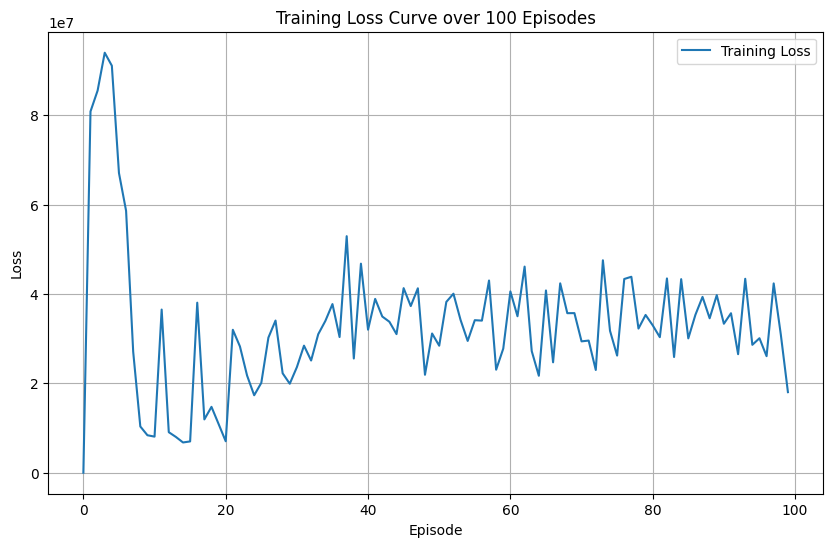

<ipython-input-8-3b34b5af8673>:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=dqn_plots_data, x='episode', y='reward', ci=None, label='Episodic Reward')


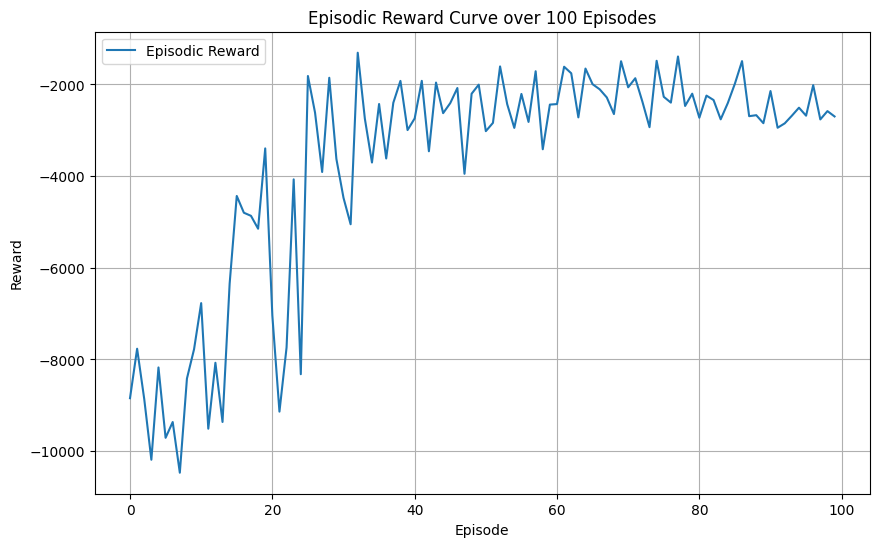

<ipython-input-8-3b34b5af8673>:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=dqn_plots_data, x='episode', y='order_quantity', ci=None, label='Order Quantity')


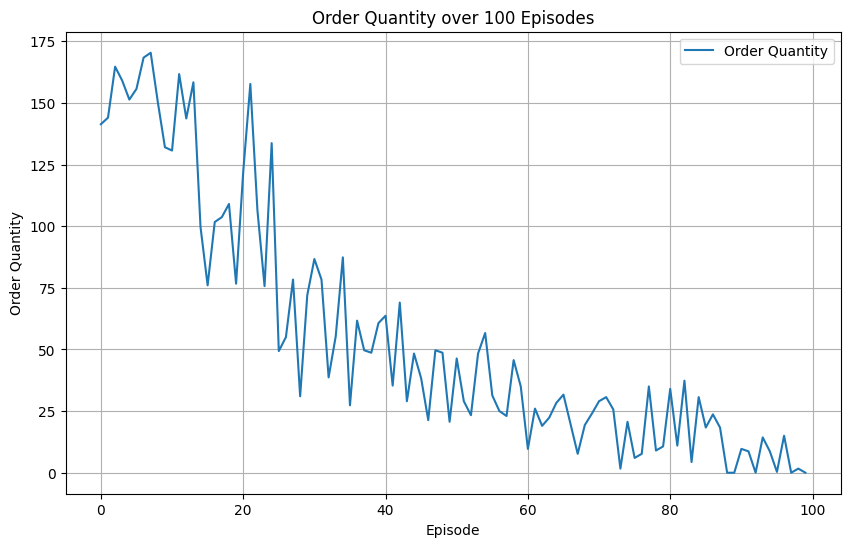

<ipython-input-8-3b34b5af8673>:46: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=dqn_plots_data, x='episode', y='wasted_units', ci=None, label='Wasted Units')


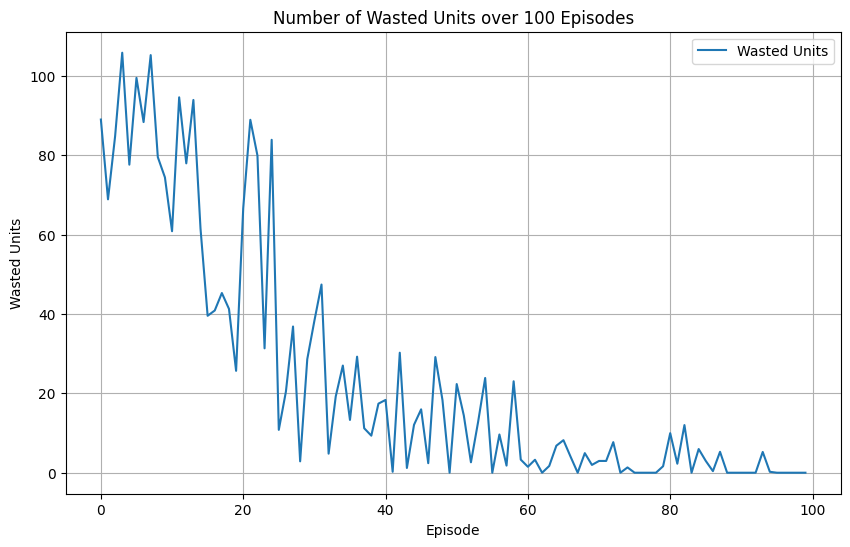

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the training data
training_data_results_path = 'DQN_training_data_results.xlsx'
dqn_plots_data = pd.read_excel(training_data_results_path)

# Ensure data is loaded correctly
dqn_plots_data.head()

# Generate plots

# 1. Training Loss Curve over 36 Episodes
plt.figure(figsize=(10, 6))
sns.lineplot(data=dqn_plots_data, x='episode', y='loss', ci=None, label='Training Loss')
plt.title('Training Loss Curve over 100 Episodes')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 2. Episodic Reward Curve over 36 Episodes
plt.figure(figsize=(10, 6))
sns.lineplot(data=dqn_plots_data, x='episode', y='reward', ci=None, label='Episodic Reward')
plt.title('Episodic Reward Curve over 100 Episodes')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)
plt.show()

# 3. Order Quantity over 36 Episodes
plt.figure(figsize=(10, 6))
sns.lineplot(data=dqn_plots_data, x='episode', y='order_quantity', ci=None, label='Order Quantity')
plt.title('Order Quantity over 100 Episodes')
plt.xlabel('Episode')
plt.ylabel('Order Quantity')
plt.legend()
plt.grid(True)
plt.show()

# 4. Number of Wasted Units over 36 Episodes
plt.figure(figsize=(10, 6))
sns.lineplot(data=dqn_plots_data, x='episode', y='wasted_units', ci=None, label='Wasted Units')
plt.title('Number of Wasted Units over 100 Episodes')
plt.xlabel('Episode')
plt.ylabel('Wasted Units')
plt.legend()
plt.grid(True)
plt.show()